In [2]:
import pandas as pd

from bengrn import get_GT_db, get_perturb_gt, get_sroy_gt, BenGRN, FILEDIR

import numpy as np
import tqdm
import scanpy as sc
import os

from huggingface_hub import hf_hub_download

from scprint import scPrint
from scprint.tasks import GNInfer
from scdataloader import Preprocessor

from bengrn import BenGRN
from anndata.utils import make_index_unique

from bengrn.base import train_classifier
from bengrn import compute_genie3
from grnndata import utils as grnutils
import joblib

from matplotlib import pyplot as plt
from scdataloader import utils as data_utils

from pyvis import network as pnx
import networkx as nx
import scipy.sparse
import gseapy as gp
from gseapy import dotplot

from scdataloader.utils import revert_to_raw

import scipy.sparse

import torch

torch.set_float32_matmul_precision("medium")

%load_ext autoreload
%autoreload 2

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/ctxcore/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


## load gt

In [ ]:
gwps = get_perturb_gt()
gwps.var.index = gwps.var.gene_name
omni = get_GT_db("omnipath")
collectri = get_GT_db("collectri")

/home/ml4ig1/Documents code/benGRN/bengrn/base.py:657: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs["organism_ontology_term_id"] = "NCBITaxon:9606"


In [ ]:
gwps = gwps.extract_links()

In [ ]:
# extracting PPI data from "computing the human interactome"
humaninter = pd.read_csv(
    "http://prodata.swmed.edu/humanPPI/bulk_download/GoodPairs.txt",
    sep="\t",
    skiprows=4,
)

In [ ]:
# getting U2OS cell map data
import json

try:
    import ndex2
except ImportError:
    os.system("uv pip install ndex2")
    import ndex2
from ndex2.cx2 import RawCX2NetworkFactory, CX2NetworkXFactory
from ndex2.cx2 import CX2NetworkPandasDataFrameFactory

# Create NDEx2 python client
client = ndex2.client.Ndex2()

# Create CX2Network factory
factory = RawCX2NetworkFactory()

# Download BioGRID: Protein-Protein Interactions (SARS-CoV) from NDEx
# https://www.ndexbio.org/viewer/networks/669f30a3-cee6-11ea-aaef-0ac135e8bacf
client_resp = client.get_network_as_cx2_stream("95bc75d5-d1d1-11ee-8a40-005056ae23aa")

# Convert downloaded network to CX2Network object
net_cx = factory.get_cx2network(json.loads(client_resp.content))

# Display information about network and output 1st 100 characters of CX2
print("Name: " + net_cx.get_name())
print("Number of nodes: " + str(len(net_cx.get_nodes())))
print("Number of nodes: " + str(len(net_cx.get_edges())))

# Creating an instance of CX2NetworkPandasDataFrameFactory
factory = CX2NetworkPandasDataFrameFactory()

# Converting CX2Network to DataFrame
cellmap = factory.get_dataframe(net_cx)


Name: U2OS AP-MS network
Number of nodes: 7543
Number of nodes: 36842


## load data

In [3]:
ls ./normalize_log

 one2one_orthologs/            task4_human.h5ad   task8_frog.h5ad
 README                        task4_mouse.h5ad   task9-1_ant.h5ad
'Supplementary Table 3.xlsx'   task6_nema.h5ad    task9-1_mouse2_adult.h5ad
 task36_sea_urchin.h5ad        task6_sty.h5ad     task9_ant.h5ad
 task36_zebrafish.h5ad         task7_cat.h5ad     task9_mouse.h5ad
 task3_cat.h5ad                task7_dog.h5ad
 task3_tiger.h5ad              task8_fish.h5ad


In [3]:
LOC = '/pasteur/appa/scratch/jkalfon/data/'

In [5]:
human = sc.read(LOC+"normalize_log/task4_human.h5ad")
mouse = sc.read(LOC+"normalize_log/task4_mouse.h5ad")

In [6]:
human.obs["organism_ontology_term_id"] = "NCBITaxon:9606"
mouse.obs["organism_ontology_term_id"] = "NCBITaxon:10090"

In [7]:
mouse = revert_to_raw(mouse)
human = revert_to_raw(human)

In [8]:
commonset = set(mouse.var.index.str.upper()) & set(human.var.index)
len(commonset)

13090

In [ ]:
human.obs.tissue.unique(), mouse.obs.tissue.unique()

(['Bladder', 'Heart', 'Kidney', 'Liver', 'Muscle']
 Categories (5, object): ['Bladder', 'Heart', 'Kidney', 'Liver', 'Muscle'],
 ['Bladder', 'Brain', 'Heart', 'Kidney', 'Liver', 'Muscle']
 Categories (6, object): ['Bladder', 'Brain', 'Heart', 'Kidney', 'Liver', 'Muscle'])

In [6]:
set(human.obs.celltype.unique().tolist()) & set(mouse.obs.celltype.unique().tolist())

{'B cell',
 'Basal cell',
 'Dendritic cell',
 'Endothelial cell',
 'Epithelial cell',
 'Erythroid cell',
 'Fibroblast',
 'Goblet cell',
 'Macrophage',
 'Mast cell',
 'Monocyte',
 'Neutrophil',
 'Smooth muscle cell',
 'T cell'}

In [9]:
human.X = scipy.sparse.csr_matrix(human.X)
mouse.X = scipy.sparse.csr_matrix(mouse.X)

In [10]:
preprocessor = Preprocessor(
    is_symbol=True, force_preprocess=True, skip_validate=True, do_postp=False
)
human_p = preprocessor(human.copy())
mouse_p = preprocessor(mouse.copy())

Dropping layers:  KeysView(Layers with keys: )
checking raw counts
removed 0 non primary cells, 52816 renamining
filtered out 5 cells, 52811 renamining
Removed 4285 genes not known to the ontology
Removed 0 duplicate genes
Added 53430 genes in the ontology but not present in the dataset
starting QC
Seeing 5255 outliers (9.95% of total dataset):
done
AnnData object with n_obs × n_vars = 52811 × 70116
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism'

In [12]:
human_p.write_h5ad(LOC+"/task4_human_preprocessed.h5ad")
mouse_p.write_h5ad(LOC+"/task4_mouse_preprocessed.h5ad")

... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical
... storing 'organism_ontology_term_id' as categorical
... storing 'symbol' as categorical
... storing 'biotype' as categorical
... storing 'organism' as categorical


## generate results

In [4]:
human_p = sc.read(LOC+"/task4_human_preprocessed.h5ad")
mouse_p = sc.read(LOC+"/task4_mouse_preprocessed.h5ad")

In [5]:
model_checkpoint_file = "../models/ji9krimq.ckpt"  # w937u4o1.ckpt"
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)
model = model.to("cuda")


FYI: scPrint is not attached to a `Trainer`.


In [6]:
human_p = human_p[human_p.X.sum(1) > 500]
human_p = human_p[
    human_p.obs.celltype.isin(
        [k for k, v in human_p.obs.celltype.value_counts().items() if v > 1000]
    )
]
human_p

View of AnnData object with n_obs × n_vars = 25574 × 70116
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [7]:
mouse_p = mouse_p[mouse_p.X.sum(1) > 500]
mouse_p = mouse_p[
    mouse_p.obs.celltype.isin(
        [k for k, v in mouse_p.obs.celltype.value_counts().items() if v > 1000]
    )
]
mouse_p

View of AnnData object with n_obs × n_vars = 14455 × 57066
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'stage', 'celltype', 'cell_lineage', 'n_genes', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'unseen_genes'

In [ ]:
metrics = {}
clf_omni = None
shapes = []
for name in list(set(human_p.obs.celltype) & set(mouse_p.obs.celltype)):
    print(name)
    print("\nhuman")
    sub = human_p[human_p.obs.celltype == name].copy()
    print(sub.shape[0])
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(sub, n_top_genes=6000)
    topk = set(sub.var.index[sub.var.highly_variable])
    is_expr = set(
        human_p.var.index[
            np.array(human_p[human_p.obs.celltype == name].X.sum(0) > 0)[0]
        ]
    )
    in_mou = set(
        human_p.var.index[human_p.var.symbol.isin(mouse_p.var.symbol.str.upper())]
    )
    print(
        len(is_expr & set(model.genes) & topk),
        len(is_expr & set(model.genes) & topk & in_mou),
    )
    genes_h = list(is_expr & set(model.genes) & topk)

    grn_inferer = GNInfer(
        how="some",
        preprocess="softmax",
        head_agg="mean",
        filtration="none",
        genelist=genes_h,
        max_cells=1024,
        num_workers=4,
        batch_size=8,
        precomp_attn=False,
        cell_type_col="celltype",
    )
    grn_h = grn_inferer(model, human_p[(human_p.X.sum(1) > 500)], cell_type=name)
    grn_h.var.index = make_index_unique(grn_h.var["symbol"].astype(str))

    print("\nmouse")
    sub = mouse_p[mouse_p.obs.celltype == name].copy()
    print(sub.shape[0])
    sc.pp.log1p(sub)
    sc.pp.highly_variable_genes(sub, n_top_genes=6000)
    topk = set(sub.var.index[sub.var.highly_variable])
    is_expr = set(
        mouse_p.var.index[
            np.array(mouse_p[mouse_p.obs.celltype == name].X.sum(0) > 0)[0]
        ]
    )
    in_hum = set(
        mouse_p.var.index[mouse_p.var.symbol.str.upper().isin(human_p.var.symbol)]
    )
    print(
        len(is_expr & set(model.genes) & topk),
        len(is_expr & set(model.genes) & topk & in_hum),
    )
    genes_m = list(is_expr & set(model.genes) & topk)

    grn_inferer.genelist = genes_m
    grn_m = grn_inferer(model, mouse_p[(mouse_p.X.sum(1) > 500)], cell_type=name)
    grn_m.var.index = make_index_unique(grn_m.var["symbol"].astype(str))
    grn_m.var.index.name = "index"
    grn_h.var.index.name = "index"
    print("\n\n")
    
    break
# grn.varp["all"] = grn.varp["GRN"]
# grn.varp["GRN"] = grn.varp["GRN"][:, :, :].mean(-1)
# metrics[celltype + "_scprint_mean"] = BenGRN(grn).scprint_benchmark()

Macrophage

human
2157


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


5720 5367


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 128/128 [00:20<00:00,  6.23it/s]


avg link count: 32729841, sparsity: 1.0

mouse
2192


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/pandas/core/util/hashing.py:330: RuntimeWarning: invalid value encountered in cast
  vals.astype(str).astype(object), hash_key, encoding


6379 5866


/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


predict epoch start


100%|██████████| 128/128 [00:21<00:00,  5.84it/s]


avg link count: 40704400, sparsity: 1.0





In [11]:
len(set(grn_m.var.index))

6379

In [12]:
grn_m.var.index.name = "index"
grn_h.var.index.name = "index"

In [13]:
grn_m.write(LOC + f"grn_task4_mouse_{name}.h5ad")
grn_h.write(LOC + f"grn_task4_human_{name}.h5ad")

In [ ]:
name = "Macrophage"

In [15]:
ls $LOC/scprint_data

ls: cannot access '/pasteur/appa/scratch/jkalfon/data//scprint_data': No such file or directory


In [16]:
from grnndata import read_h5ad

grn_m = read_h5ad(LOC+ f"grn_task4_mouse_{name}.h5ad")
grn_h = read_h5ad(LOC+ f"grn_task4_human_{name}.h5ad")

# 1. Hub genes

We will use 2 different definition of centrality to compare the hubs of the networks in both states. The first one is the degree centrality, which is the number of connections of a node. The second one is the eigenvector centrality, which is the sum of the centrality of the neighbors of a node.

For each gene we mostly interogate their meaning with genecards, e.g. https://www.genecards.org/cgi-bin/carddisp.pl?gene=CD99

In [ ]:
# https://string-db.org/cgi/network?taskId=bCpYzN7T6Uz9&sessionId=b9ed9TAsb4ro
["PRDM1", "PAX5", "STAT3", "BACH2", "PRMT5", "TP53", "XBP1", "SDC1", "HDAC2", "EHMT2"]

In [21]:
grn_m.var

,n_cells,uid,symbol,biotype,organism_id,branch_id,mt,ribo,hb,organism,ensembl_gene_id,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,TFs
symbol,,,,,,,,,,,,,,,,,,
Cdc45,211.0,2IgYexLtRNg8,Cdc45,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000028,211,0.007117,0.007092,99.329605,224.0,5.416101,False
Apoh,395.0,u7T0dhlTR2C5,Apoh,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000049,395,0.017570,0.017417,98.744996,553.0,6.317165,False
Cav2,3846.0,7R79lbqgSiIP,Cav2,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000058,3846,0.153142,0.142491,87.780390,4820.0,8.480737,False
Cox5a,11798.0,2swpuUNdoHDH,Cox5a,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000088,11798,0.630679,0.488997,62.515092,19850.0,9.896009,False
Tfe3,635.0,4dTz1ex7k4Df,Tfe3,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000000134,635,0.020493,0.020286,97.982462,645.0,6.470799,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Lilrb4a,2821.0,6OkKaJXIMGvy,Lilrb4a,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000112148,2821,0.124134,0.117013,91.037046,3907.0,8.270781,False
Zfp935,51.0,339jjhs1URcw,Zfp935,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000113450,51,0.001652,0.001651,99.837961,52.0,3.970292,False
Lin54,233.0,6LbSjDBWY5zW,Lin54,protein_coding,144,1,False,False,False,NCBITaxon:10090,ENSMUSG00000118665,233,0.007657,0.007628,99.259706,241.0,5.488938,False


In [6]:
# between the two networks we have ~3000 genes in common over their 4000 genes
grn_m.var.index = grn_m.var.symbol.str.upper()
common = set(grn_h.var.index) & set(grn_m.var.index)
len(common)

1650

In [28]:
# hub genes based on edge centrality (number of connections / strength of connections)
grn_h.grn.sum(0).sort_values(ascending=False).head(20)

symbol
GPR183     129.212936
UGT1A9      90.286057
TMSB4X      82.656120
RPL23       49.138138
JCHAIN      47.933247
MOCOS       44.518085
RPL15       38.902645
CSTB        38.207447
S100A5      38.182125
RGS2        36.185287
SLC47A2     35.361763
RPS6        32.497929
ITM2C       28.860186
BLOC1S3     28.255081
HLA-C       23.455450
HSPA6       23.279291
EEF1A1      22.035364
GPX1        21.385178
VASP        21.068890
RGS1        20.219160
dtype: float32

In [ ]:
# without taking in account genes that are not present in the mouse network
grn_h.grn.sum(0).loc[list(common)].sort_values(ascending=False).head(20)

symbol
GPR183    129.212936
TMSB4X     82.656120
JCHAIN     47.933247
S100A5     38.182125
RGS2       36.185287
ITM2C      28.860186
GPX1       21.385178
RGS1       20.219160
OGT        19.938852
UBE2S      19.495527
ACTB       18.731108
IFITM1     17.795893
FCER1G     15.502327
CREM       14.854994
B2M        14.243589
CST3       13.433418
RPL41      12.664364
CD83       12.439404
RPL3       12.226817
CD52       11.877687
dtype: float32

ACTB=ACTB (most expressed in B cell, motility, key linked gene is CFL1 top 10 in mouse)

B2M=B2M (serum protein found in association with the major histocompatibility complex, linked to HLA-C, top 20 in human genes)

TMSB4X = TMSB10, TMSB4X (Thymosin Beta, cell prolif, highly linked to actin and ACTB)

CD83, CD52 = CD52 CD3D, (CD74)  ( immunoglobulin superfamily of receptors, Regulate b cell function, esp CD83, CD52 less)

S100A5 = S100A6 (key cell process regulation with calcium binding, both in top 3 relation to TOP53)

RPL41, RPL3 = RPL10, RPLP1 (ribosomal proteins, much more for human in top50, highly co-regulated, often together, have in important impact on mRNA content by working on splicing, mRNA stability, sequestration of TFs )

[RPS6] = RPS27A, RPS24, (RPS28) (same)

[FTL] = FTH1 (iron storage)
    MEF2C, JUNB (key TF in b cells, https://pubmed.ncbi.nlm.nih.gov/12907453/, https://pmc.ncbi.nlm.nih.gov/articles/PMC2518613/)

RGS2, RGS1, GPR183, GPX1 (G protein Receptor, signaling members, super important b cell members)

JCHAIN, ITM2C, OGT, UBE2S, IFITM1, CREM, FCER1G, CST3
    TOP2A, CRIP1, PPP1R15A, MS4A1, PPIA, PTMA

"Immunoglobulin Receptor Binding (GO:0034987)" JCHAIN
"B cell activation", "host pathogen pathways" IFITM1, FCER1G "B cell activation" MS4A1 == "virus detection" PPIA, PPP1R15A
"MHC Class II Protein Complex Binding" MS4A1, "HSPA1A" (MHC related)(PPP1R15A;PTMA)
"circadian rythm" CST3;CREM;OGT = TOP2A

() = in the non matching genes
[] = in the top 50

can find homologs and might use some genes that are similar when others are not available or expressed

bias on the 1000 cells and which ones had which genes expressed
worked using only human / mouse known orhologs, but some relationships might not have been found

Generically, many genes with high importance in generic cellular processes, and some with high importance in B cell function.

Even more interesting, many of these genes are listed in papers about the transcriptional control dynamic of B cell function using paired single cell ATAC-seq - CHip-seq - RNA-seq  https://www.biorxiv.org/content/10.1101/2022.02.23.481342v2.full.pdf "Fate-resolved gene regulatory signatures of individual B lymphocytes in the early1stages of Epstein-Barr Virus infection2"
(PPP1R-, TOP2A, MS4A1, FCER2/FCER1G, JCHAIN, FTH1, FTL, TMSB10, TMSB4X, GPR183, (likely other members of the G protein family), numerous ribosomal subunit genes (listed as example: RPS27A) and also))

In [ ]:
CD27

In [21]:
# Assuming 'node_names' contains the list of gene names.
# Note: it seems with enrichr, one can only use one gene set at a time, choose accordingly
enr = gp.enrichr(
    gene_list=["JCHAIN", "ITM2C", "OGT", "UBE2S", "IFITM1", "CREM", "FCER1G", "CST3"],
    # [
    #    "TOP2A",
    #    "CRIP1",
    #    "PPP1R15A",
    #    "MS4A1",
    #    "PPIA",
    #    "PTMA",
    # ], #["JCHAIN", "ITM2C", "OGT", "UBE2S", "IFITM1", "CREM", "FCER1G", "CST3"],
    gene_sets=[
        "WikiPathway_2023_Human"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=grn_h.var.symbol.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.1].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathway_2023_Human,Circadian Rhythm Genes WP3594,0.000062,0.000863,0,0,58.992000,571.898156,CST3;CREM;OGT
1,WikiPathway_2023_Human,Sleep Regulation WP3591,0.006420,0.044875,0,0,236.333333,1193.097618,CST3
2,WikiPathway_2023_Human,mBDNF And proBDNF Regulation Of GABA Neurotran...,0.009616,0.044875,0,0,141.742857,658.297569,CREM
3,WikiPathway_2023_Human,Immune Response To Tuberculosis WP4197,0.014394,0.050379,0,0,88.535714,375.475776,IFITM1
4,WikiPathway_2023_Human,16P11 2 Distal Deletion Syndrome WP4950,0.020733,0.055545,0,0,58.976190,228.594076,IFITM1
5,WikiPathway_2023_Human,Amyotrophic Lateral Sclerosis ALS WP2447,0.027036,0.055545,0,0,44.196429,159.575072,CST3
6,WikiPathway_2023_Human,Microglia Pathogen Phagocytosis Pathway WP3937,0.030174,0.055545,0,0,39.269841,137.474574,FCER1G
7,WikiPathway_2023_Human,Host Pathogen Interaction Of Human Coronavirus...,0.031740,0.055545,0,0,37.195489,128.331003,IFITM1
8,WikiPathway_2023_Human,SARS CoV 2 Innate Immunity Evasion And Cell Sp...,0.048818,0.072653,0,0,23.504762,70.976059,IFITM1
9,WikiPathway_2023_Human,Extrafollicular And Follicular B Cell Activati...,0.051895,0.072653,0,0,22.026786,65.166888,IFITM1


In [ ]:
TOP = 100
set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)

{'ACTB',
 'ATP1A1',
 'ATP4A',
 'B2M',
 'BIRC5',
 'CCDC89',
 'CCNB2',
 'CD3D',
 'CD52',
 'CD74',
 'CFL1',
 'CHAD',
 'COLQ',
 'COX7B',
 'COX8B',
 'CRIP1',
 'CTLA2A',
 'CYP2F2',
 'DUSP11',
 'FAM120B',
 'FCMR',
 'FTH1',
 'GIMAP4',
 'GM266',
 'H2-AA',
 'H2-AB1',
 'H2-EB1',
 'H3F3B',
 'HSP90AB1',
 'JCHAIN',
 'JUNB',
 'LIN54',
 'LY6D',
 'LYPD2',
 'MEF2C',
 'MPC1',
 'MRGPRF',
 'MS4A1',
 'MT-CYTB',
 'MT-ND1',
 'MT-ND2',
 'MT-ND4',
 'NDC80',
 'NWD1',
 'OXCT1',
 'PCDHGA12',
 'PCLAF',
 'PEX11G',
 'PPIA',
 'PPP1R15A',
 'PSME1',
 'PTMA',
 'PTPRB',
 'PTPRCAP',
 'RPL10',
 'RPL13',
 'RPL13A',
 'RPL14',
 'RPL18',
 'RPL18A',
 'RPL3',
 'RPL37',
 'RPL37A',
 'RPL38',
 'RPL39',
 'RPL4',
 'RPL6',
 'RPLP0',
 'RPLP1',
 'RPS12',
 'RPS16',
 'RPS17',
 'RPS18',
 'RPS19',
 'RPS23',
 'RPS24',
 'RPS27',
 'RPS27A',
 'RPS28',
 'RPS29',
 'RPS8',
 'RPSA',
 'RRM2',
 'S100A4',
 'S100A6',
 'SELENOP',
 'SLC25A5',
 'SNRPG',
 'TAF10',
 'TIFA',
 'TMEM132E',
 'TMEM176B',
 'TMSB10',
 'TMSB4X',
 'TOMM7',
 'TOP1',
 'TOP2A',
 'UBB',


In [19]:
# mouse hub genes
grn_m.grn.sum(0).sort_values(ascending=False).head(50)

symbol
PEX11G      75.901932
TMSB10      48.729370
CD52        43.457500
RPL38       38.743034
PSME1       37.857132
RPLP1       30.391418
MS4A1       27.636669
CFL1        27.622765
CYP2F2      26.343971
PCDHGA12    24.471041
RPL18       22.066275
NWD1        21.477045
RPS28       21.305538
RPL37       21.086893
PPP1R15A    20.715763
RPL4        19.652786
XRN2        19.504841
RPL13A      19.381565
CD74        18.533308
TMSB4X      16.875311
RPS16       16.819887
RPS27       16.599045
H2-AB1      16.233440
YPEL1       15.096142
TIFA        14.418551
RPL39       14.415133
ACTB        14.282932
H2-EB1      13.879421
RPLP0       13.830363
RPS12       13.655597
H2-AA       13.595297
CRIP1       13.384311
RPL18A      13.290665
RPS24       13.193646
TOP2A       12.817780
MT-CYTB     12.751656
MT-ND2      12.366352
ATP1A1      11.586185
RPS23       11.549526
RPL10       11.413186
RPL14       11.350452
RPS18       11.322289
MEF2C       10.899960
LIN54       10.674285
CTLA2A      10.504695
S10

In [22]:
# without taking in account genes not present in the human network
grn_m.grn.sum(0).loc[list(common)].sort_values(ascending=False).head(20)

symbol
TMSB10      48.729370
CD52        43.457500
RPLP1       30.391418
MS4A1       27.636669
PPP1R15A    20.715763
TMSB4X      16.875311
ACTB        14.282932
CRIP1       13.384311
RPS24       13.193646
TOP2A       12.817780
RPL10       11.413186
MEF2C       10.899960
S100A6      10.468975
FTH1        10.270110
CD3D         9.877011
B2M          9.325386
PPIA         8.682125
RPS27A       8.245732
JUNB         8.119863
PTMA         7.803161
dtype: float32

In [ ]:
TOP = 20
set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index) & set(
    grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index
)

{'TMSB4X'}

In [43]:
# top differential hubs
TOP = 100
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.index) & set(grn_m.var.index))
)

{'MPC1', 'CD3D', 'PPP1R15A', 'CRIP1', 'RPS24', 'RPS19', 'TMEM176B', 'TMSB10', 'COX7B', 'JUNB', 'CCNB2', 'FTH1', 'MEF2C', 'PPIA', 'S100A4', 'TOP2A', 'FCMR', 'S100A6', 'TAF10', 'OXCT1', 'RRM2'}
{'RPL8', 'RPS14', 'RPS2', 'HERPUD1', 'CREM', 'CST3', 'UBC', 'IFITM1', 'CALM2', 'CKS2', 'GPX1', 'RPL41', 'FKBP2', 'HSPA1B', 'GPR183', 'SLC38A2', 'TUBB4B', 'CD83', 'S100A5', 'HSPA1A', 'FCER1G', 'UBE2S', 'RGS1', 'OGT', 'N4BP2L2', 'GZMA', 'TYROBP', 'RGS2', 'ITM2C', 'RPL32', 'NFKBIA'}


In [ ]:
TREM
PPARG
CD36, CD9

In [ ]:
TOP = 20
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'MS4A1', 'RPLP1', 'RPS24', 'TSPAN14', 'RPL10'}
{'CST3', 'RGS2', 'NDUFC2', 'EPB41L4B'}


In [1]:
TOP = 50
# in m not in h
print(
    (
        set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.grn.sum(0).sort_values(ascending=False).head(TOP).index)
        - set(grn_m.grn.sum(0).sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

NameError: name 'grn_m' is not defined

In [49]:
# we now compute eigen centrality creating a sparse network by only keeping the top 20 neighbors for each gene in the network
TOP = 20

grnutils.get_centrality(grn_h, TOP, top_k_to_disp=0)
grnutils.get_centrality(grn_m, TOP, top_k_to_disp=0)


Top central genes: []
Top central genes: []


[]

In [50]:
grn_h.var.centrality.sort_values(ascending=False).head(10)

symbol
TMSB4X    0.282618
GPR183    0.282618
RPS6      0.282618
RPL23     0.273226
RGS2      0.257952
JCHAIN    0.257704
SRGN      0.232934
GPX1      0.228362
RPL17     0.217176
B2M       0.208795
Name: centrality, dtype: float64

In [51]:
grn_m.var.centrality.sort_values(ascending=False).head(10)

symbol
RPLP1      0.273881
PSME1      0.273881
TMSB10     0.273881
RPL13A     0.271627
RPL4       0.264553
RPS27      0.253747
XRN2       0.249243
RPL37      0.239994
MT-CYTB    0.228202
RPL10      0.227350
Name: centrality, dtype: float64

In [ ]:
TOP = 10
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'RPLP1', 'TSPAN14', 'RPL10'}
{'NDUFC2'}


In [ ]:
scipy.stats.spearmanr(np.array(grn_m.X.sum(0))[0], grn_m.grn.sum(0).values)

SignificanceResult(statistic=np.float64(0.29967283792310595), pvalue=np.float64(4.3875743887677246e-75))

In [ ]:
np.corrcoef(np.array(grn_m.X.sum(0))[0], grn_m.grn.sum(0).values)[0, 1]

np.float64(0.5566375997092329)

In [ ]:
TOP = 20
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'TSPAN14', 'SIN3B', 'RPS24'}
{'CST3', 'RGS2', 'NDUFC2'}


In [ ]:
TOP = 50
# in m not in h
print(
    (
        set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)
# in h not in m
print(
    (
        set(grn_h.var.centrality.sort_values(ascending=False).head(TOP).index)
        - set(grn_m.var.centrality.sort_values(ascending=False).head(TOP).index)
    )
    & (set(grn_h.var.symbol) & set(grn_m.var.symbol))
)

{'IFITM3', 'TIMM13', 'NCOR1', 'MS4A1', 'RPS24', 'TMEM160', 'TSPAN14', 'SIN3B'}
{'NFKBIA', 'ITM2C', 'SNX9', 'RGS2', 'SNRPF', 'RGS1', 'NDUFC2', 'EPB41L4B', 'CST3', 'SMC2'}


# 2. Network similarity

We now look at the similarity of the two networks based on general overlap of their top K edges across their common nodes

In [35]:
K = 20
subgrn_h = grn_h.get(common).grn
subgrn_h = subgrn_h.apply(lambda row: row >= row.nlargest(K).min(), axis=1)

subgrn_m = grn_m.get(common).grn
subgrn_m = subgrn_m.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
(subgrn_m & subgrn_h).sum(1).mean() / K


np.float64(0.22103030303030305)

In [37]:
# Calculate dissimilarity for each common CD gene in human compared to mouse
dissim_scores = {}
for gene in subgrn_m.index:
    # Count overlapping connections (human vs mouse)
    overlap = (subgrn_m.loc[gene] & subgrn_h.loc[gene]).sum()
    # Dissimilarity score: how many top-K human connections are NOT present in mouse
    dissim_scores[gene] = (subgrn_m.loc[gene] & ~subgrn_h.loc[gene]).sum()

# Sort genes by dissimilarity (highest first)
dissim_df = pd.Series(dissim_scores).sort_values(ascending=False)
print("genes with most dissimilar top-K connections (mouse vs human):")
print(dissim_df.head(60))

# Show the most dissimilar genes
most_dissimilar = dissim_df.head(60).index.tolist()
print(f"\nMost dissimilar genes: {most_dissimilar}")

genes with most dissimilar top-K connections (mouse vs human):
TOP2A       18
UBE3A       18
CCNB2       18
ACTR10      18
KIF23       18
UBE2C       18
PRR11       18
RRM2        18
DHFR        18
SIVA1       18
NUSAP1      18
PAICS       18
SNRNP27     18
KNSTRN      18
KIF18A      18
KIF22       18
GMNN        18
PLK1        18
CAT         18
CENPH       18
MCM4        18
EXOSC8      18
BAZ1B       18
CENPK       18
SDC4        18
BRCA1       18
SEC63       18
RRM1        18
RFC4        18
MRPL34      18
RACGAP1     18
SPOP        18
CCNB1       18
CCNL2       18
RRP7A       18
GLRX5       18
DMKN        18
PARPBP      18
GINS2       18
SLC25A39    18
NSRP1       18
FEN1        18
SUCLG1      18
MCM7        18
CDC20       18
AK2         18
GSDMD       18
ASF1B       18
MELK        18
RAB11A      18
SPDL1       18
GCH1        18
GINS1       18
SHCBP1      18
KCNK1       18
SPPL2A      18
NDUFA4L2    18
DLGAP5      18
RFC3        18
DNAJC19     18
dtype: int64

Most dissimilar genes: 

In [54]:
enr = gp.enrichr(
    gene_list=most_dissimilar,
    gene_sets=[
        "WikiPathway_2023_Human"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=common,
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.05].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathway_2023_Human,Retinoblastoma Gene In Cancer WP2446,1.200350e-09,9.602802e-08,0,0,19.605442,402.708575,TOP2A;DHFR;CCNB2;RFC3;CCNB1;RRM1;RRM2;RFC4;MCM...
1,WikiPathway_2023_Human,Pyrimidine Metabolism And Related Diseases WP4225,4.578769e-05,1.831508e-03,0,0,inf,inf,RRM1;RRM2;TYMS
2,WikiPathway_2023_Human,Biomarkers For Pyrimidine Metabolism Disorders...,1.783989e-04,3.761073e-03,0,0,83.631579,721.865000,RRM1;RRM2;TYMS
3,WikiPathway_2023_Human,Cell Cycle WP179,2.345519e-04,3.761073e-03,0,0,8.722222,72.898882,CDC20;CCNB2;CCNB1;MCM7;PLK1;MCM4
4,WikiPathway_2023_Human,DNA Replication WP466,2.378167e-04,3.761073e-03,0,0,11.954545,99.748852,RFC3;RFC4;MCM7;GMNN;MCM4
5,WikiPathway_2023_Human,Fluoropyrimidine Activity WP1601,2.820805e-04,3.761073e-03,0,0,18.857143,154.125426,DHFR;RRM1;RRM2;TYMS
6,WikiPathway_2023_Human,Gastric Cancer Network 2 WP2363,6.293639e-04,7.192730e-03,0,0,14.125000,104.112563,TOP2A;RFC3;RFC4;UBE2C
7,WikiPathway_2023_Human,Gastric Cancer Network 1 WP2361,8.463872e-04,8.463872e-03,0,0,27.842105,196.969909,TOP2A;UBE2C;MCM4
8,WikiPathway_2023_Human,Serine Metabolism WP4688,1.301037e-03,1.156477e-02,0,0,inf,inf,DHFR;TYMS
9,WikiPathway_2023_Human,DNA IR Damage And Cellular Response Via ATR WP...,6.127788e-03,4.898832e-02,0,0,10.407895,53.027406,FEN1;PLK1;BRCA1


# res 

- seeing CD34 first is really cool (when most dissim human / mouse)
  
# pathway analysis
## mouse vs human
- many cell cyle genes
- replication genes
- G2-M Checkpoint / Mitotic Spindle
- DNA synthesis and replication, unwinding of dna...
- microtubulue, and tubulin stuff
- CDK1, MCM2, ..
## human vs mouse
- cytokine signaling
- Fluoropyrimidine, Pyrimidine and serine metabolism
- same otherwise

key differences in B-cell this also changes how they respond to cytokines and influence in how they divide and replicate, 
That difference can be in part driven by differences in nucleotide metabolism, which is key for DNA synthesis and replication,

	•	Ortholog expression / enzyme activities differ: The DPD example shows mouse > human in hepatic activity. That suggests species have evolved different baseline enzyme capacities.
	•	Organ/tissue distribution of enzymes differs: The capecitabine study showed different organ/intestinal vs hepatic enzyme distributions in mice vs humans. That implies that even with the same genes, tissue‐expression context differs across species.
	•	Differences in precursor supply / flux: For serine, de novo synthesis vs uptake differs between species/tissue contexts. So B-cells in mouse may rely more on one mode (say, uptake) vs human B-cells another.
	•	Differences in regulation by signalling or metabolism: Immune cells in different species may use different metabolic wiring (e.g., nutrient transporter expression, mitochondrial vs glycolytic flux). These differences may ripple through nucleotide and serine metabolism.
	•	Evolutionary adaptation to lifespan, cell turnover, and metabolic demand: Mice have much faster cell proliferation rates, higher basal metabolic rates, shorter lifespans; this may drive differences in how strongly they rely on de novo synthesis vs salvage pathways, or how tightly pyrimidine catabolism is regulated.


In [47]:
# Calculate dissimilarity for each common CD gene in human compared to mouse
dissim_scores = {}
for gene in subgrn_h.index:
    # Count overlapping connections (human vs mouse)
    overlap = (subgrn_h.loc[gene] & subgrn_m.loc[gene]).sum()
    # Dissimilarity score: how many top-K human connections are NOT present in mouse
    dissim_scores[gene] = (subgrn_h.loc[gene] & ~subgrn_m.loc[gene]).sum()

# Sort genes by dissimilarity (highest first)
dissim_df = pd.Series(dissim_scores).sort_values(ascending=False)
print("genes with most dissimilar top-K connections (human vs mouse):")
print(dissim_df.head(60))

# Show the most dissimilar genes
most_dissimilar = dissim_df.head(60).index.tolist()
print(f"\nMost dissimilar genes: {most_dissimilar}")

genes with most dissimilar top-K connections (human vs mouse):
GINS1       18
KIF22       18
UBE3A       18
MELK        18
SDC4        18
RFC3        18
GCH1        18
ACTR10      18
NSD1        18
PRR11       18
SHCBP1      18
SIVA1       18
BAZ1B       18
UBE2C       18
DMKN        18
PARPBP      18
RRM2        18
TXN2        18
CENPK       18
SPDL1       18
RAB11A      18
MCM7        18
MCM4        18
SLC25A39    18
CCNB1       18
TOP2A       18
CCNL2       18
CENPH       18
NUSAP1      18
KIF23       18
DHFR        18
SEC63       18
BRCA1       18
SNRNP27     18
GLRX5       18
ASF1B       18
GSDMD       18
SPPL2A      18
GINS2       18
RRM1        18
RRP7A       18
RACGAP1     18
FEN1        18
TYMS        18
PLK1        18
CCNB2       18
AK2         18
SUCLG1      18
CDC20       18
GMNN        18
RFC4        18
DNAJC19     18
DLGAP5      18
PAICS       18
NSRP1       18
MRPL34      18
EXOSC8      18
SPC25       18
KCNK1       18
NDUFA4L2    18
dtype: int64

Most dissimilar genes: 

In [27]:
dissim_df.index[dissim_df.index.str.startswith("CD")]

Index(['CDC20', 'CDK1', 'CDC16', 'CD34', 'CDCA3', 'CDKAL1', 'CDO1', 'CDK4',
       'CD200R1', 'CDC34', 'CDKN2AIPNL', 'CDK14', 'CDKN1A', 'CDC37L1', 'CDC26',
       'CD36', 'CD93', 'CD68', 'CD83', 'CD14', 'CD69', 'CD40', 'CD47', 'CDC37',
       'CD63', 'CD46', 'CD52', 'CD3D'],
      dtype='object')

In [31]:
K = 5
subgrn_h = grn_h.get(
    set(common) & set(grn_h.var.index[grn_h.var.index.str.match(r"CD\d{1,4}")])
).grn
subgrn_h = subgrn_h.apply(lambda row: row >= row.nlargest(K).min(), axis=1)

subgrn_m = grn_m.get(set(common) & set(grn_m.var.index[grn_m.var.index.str.match(r"CD\d{1,4}")])).grn
subgrn_m = subgrn_m.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
(subgrn_m & subgrn_h).sum(1).mean() / K

np.float64(0.5857142857142856)

In [ ]:
https://chatgpt.com/share/68ee40f1-7380-8000-b5ef-585db46704e9

In [33]:
subgrn_m

symbol,CD52,CD36,CD83,CD46,CD34,CD40,CD68,CD200R1,CD63,CD93,CD69,CD3D,CD14,CD47
symbol,,,,,,,,,,,,,,
CD52,True,True,False,True,False,False,False,False,True,False,False,True,False,False
CD36,True,True,False,True,False,False,False,False,True,False,False,True,False,False
CD83,True,True,True,False,False,False,False,False,True,False,False,True,False,False
CD46,True,True,False,True,False,False,False,False,True,False,False,True,False,False
CD34,True,True,False,True,False,False,False,False,True,False,False,True,False,False
CD40,True,True,False,True,False,True,False,False,False,False,False,True,False,False
CD68,True,True,False,True,False,False,False,False,True,False,False,True,False,False
CD200R1,True,True,False,True,False,True,False,False,False,False,False,True,False,False
CD63,True,True,False,True,False,False,False,False,True,False,False,True,False,False


In [ ]:
CD36, CD83, CD46, CD63, 

In [32]:
subgrn_h

symbol,CD40,CD69,CD83,CD46,CD93,CD68,CD36,CD63,CD200R1,CD3D,CD52,CD14,CD34,CD47
symbol,,,,,,,,,,,,,,
CD40,False,True,True,False,False,False,False,True,False,True,True,False,False,False
CD69,False,True,True,False,False,False,False,True,False,True,True,False,False,False
CD83,False,True,True,False,False,False,False,True,False,True,True,False,False,False
CD46,False,True,True,False,False,False,False,True,False,True,True,False,False,False
CD93,False,True,True,False,False,False,True,False,False,True,True,False,False,False
CD68,False,True,True,False,False,False,False,True,False,True,True,False,False,False
CD36,False,True,True,False,False,False,True,False,False,True,True,False,False,False
CD63,False,True,True,False,False,False,False,True,False,True,True,False,False,False
CD200R1,False,True,True,False,False,False,True,False,False,True,True,False,False,False


In [29]:
# Calculate dissimilarity for each common CD gene
dissim_scores = {}
for gene in subgrn_h.index:
    # Count overlapping connections
    overlap = (subgrn_h.loc[gene] & subgrn_m.loc[gene]).sum()
    # Dissimilarity score (lower overlap = higher dissimilarity)
    dissim_scores[gene] = K - overlap

# Sort genes by dissimilarity (highest first)
dissim_df = pd.Series(dissim_scores).sort_values(ascending=False)
print("CD genes with most dissimilar top-K connections:")
print(dissim_df.head(10))

# Show the most dissimilar genes
most_dissimilar = dissim_df.head(5).index.tolist()
print(f"\nMost dissimilar CD genes: {most_dissimilar}")

CD genes with most dissimilar top-K connections:
CD40       6
CD69       6
CD83       6
CD46       6
CD93       6
CD68       6
CD36       6
CD63       6
CD200R1    6
CD3D       6
dtype: int64

Most dissimilar CD genes: ['CD40', 'CD69', 'CD83', 'CD46', 'CD93']


In [ ]:
K = 20
subgrn_h = grn_h.get(set(common) & set(grn_h.var.index[grn_h.var.index.str.startswith('CD')])).grn
subgrn_h = subgrn_h.apply(lambda row: row >= row.nlargest(K).min(), axis=1)

subgrn_m = grn_m.get(set(common) & set(grn_m.var.index[grn_m.var.index.str.startswith('CD')])).grn
subgrn_m = subgrn_m.apply(lambda row: row >= row.nlargest(K).min(), axis=1)
(subgrn_m & subgrn_h).sum(1).mean() / K

In [9]:
grn_h.get('FPR1')

GRnnData object with n_obs × n_vars = 85 × 0
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'tissue', 'n_genes', 'n_counts', 'sample', 'stage', 'celltype', 'batch', 'organism_ontology_term_id', 'nnz', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'n_cells', 'uid', 'symbol', 'biotype', 'organism_id', 'branch_id', 'mt', 'ribo', 'hb', 'organism', 'ensembl_gene_id', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'TFs'
    uns: 'regulated_genes'
    varm: 'Targets', 'Regulators'
    varp: 'GRN'
    with a grn of 0 elements

when looking at the top 20 connection for each genes in the network we see that on average only 50% of them agree between the two networks

# 3. Network communities

Again looking at the top 20 connections for each gene in the network we use the leiden (or louvain) algorithm to find communities in both networks. 

We then study the hub of these communities as well as their enrichment using enrichr and ontology databases. We will only look at communities between 20 and 200 genes


In [52]:
TOP = 20

grnutils.get_centrality(grn_h, TOP, top_k_to_disp=0)
grnutils.get_centrality(grn_m, TOP, top_k_to_disp=0)


Top central genes: []
Top central genes: []


[]

In [98]:
grn_h = grnutils.compute_cluster(grn_h, 0.1, max_comm_size=100)
grn_m = grnutils.compute_cluster(grn_m, 3.0, max_comm_size=0)

In [99]:
# our communities
grn_h.var["cluster_0.1"].value_counts()  # .head(10)

cluster_0.1
30     100
9      100
10     100
12     100
11     100
      ... 
482      1
481      1
480      1
479      1
489      1
Name: count, Length: 1405, dtype: int64

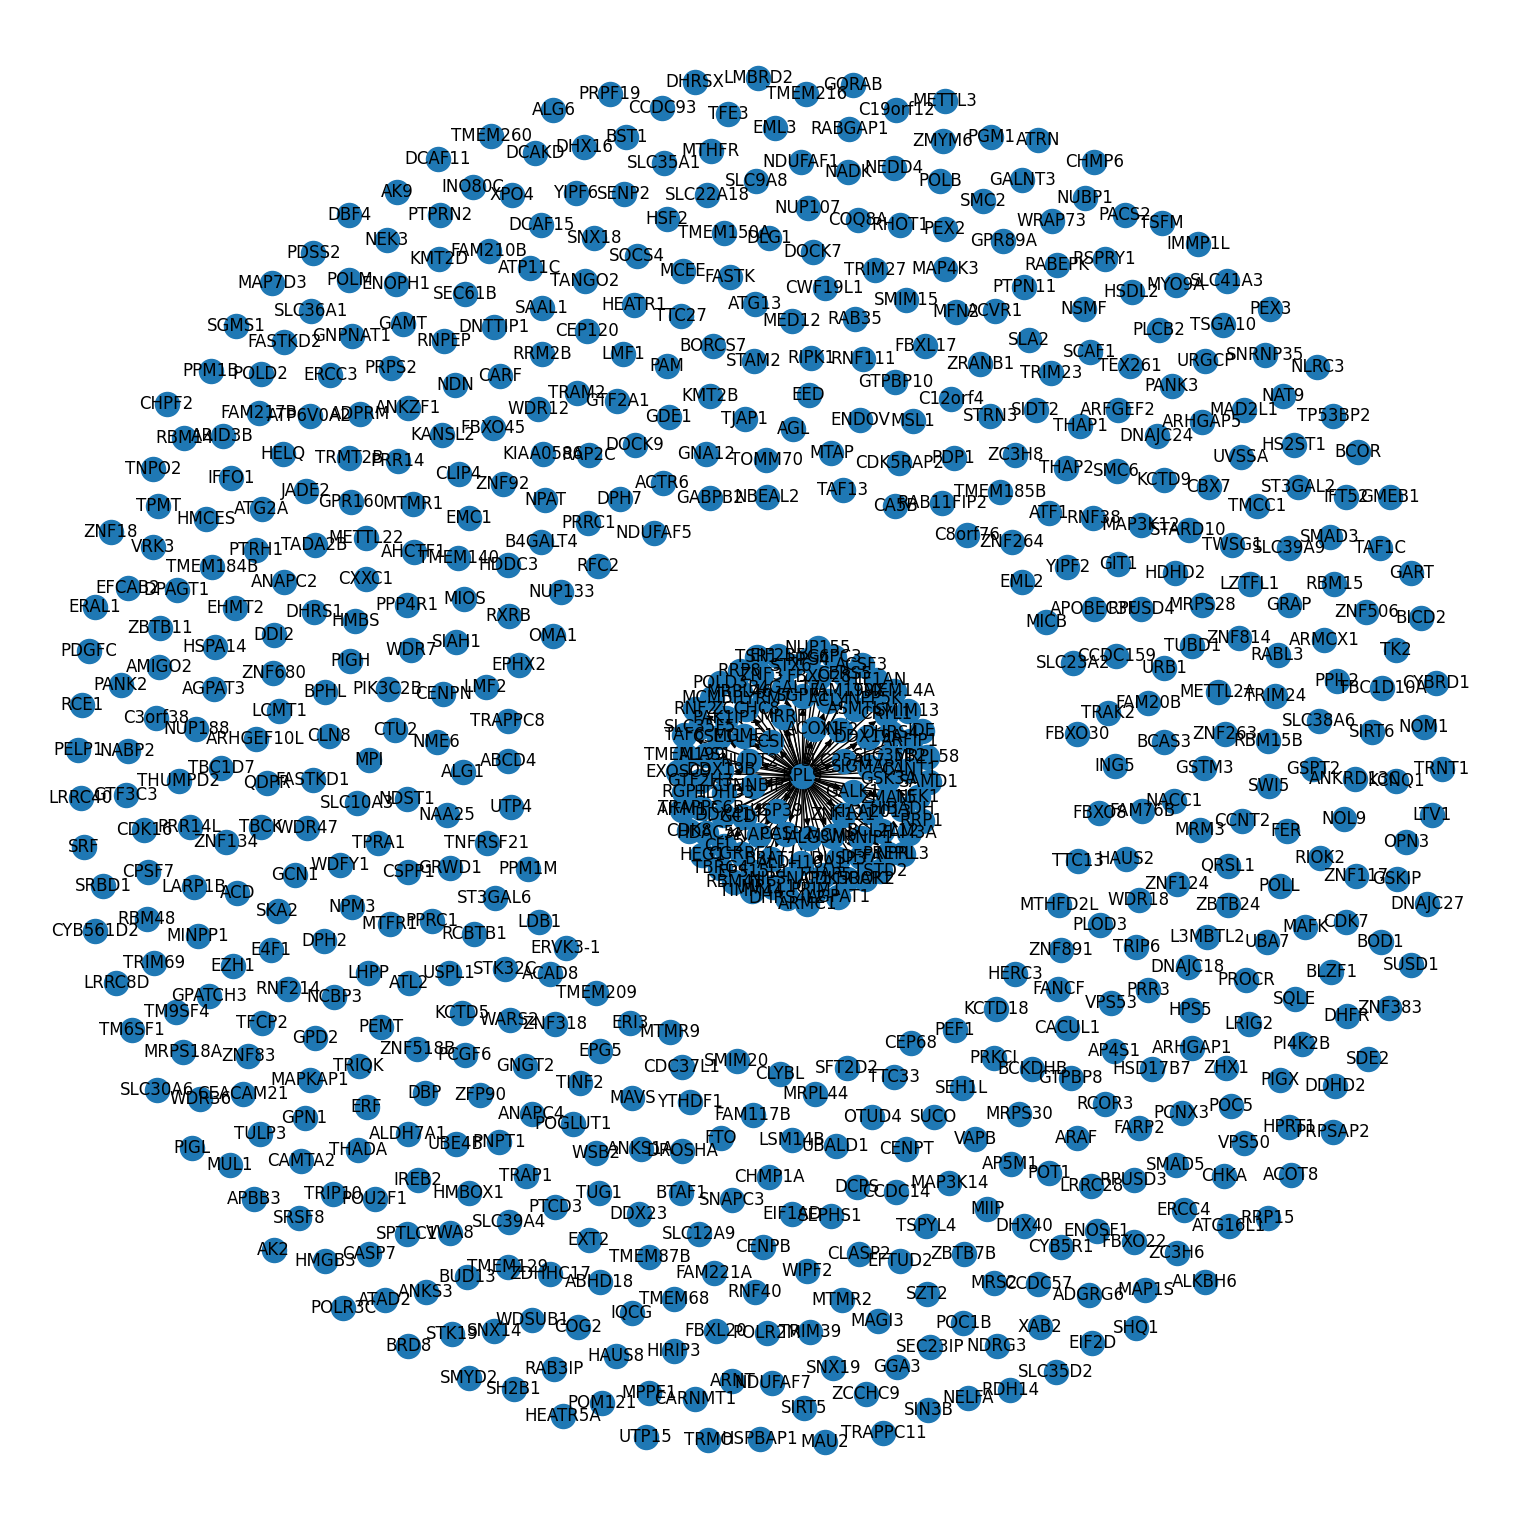

In [97]:
G = grn_h.plot_subgraph(
    grn_h.var[grn_h.var["cluster_0.1"] == "4"].index.tolist(),
    only=100,
    interactive=False,
)  #


In [ ]:
# if you want to draw better looking networks
pnet = pnx.Network(notebook=True, cdn_resources="remote", directed=True)
pnet.from_nx(G)
# first_node = list(G.nodes)[-1]
# pnet.get_node(first_node)['color'] = "red"
pnet.save_graph("../figures/pyvis/grn_c_4.html")

In [114]:
"TP63" in grn_h.var.symbol.tolist()

False

In [108]:
# Assuming 'node_names' contains the list of gene names.
# Note: it seems with enrichr, one can only use one gene set at a time, choose accordingly
enr = gp.enrichr(
    gene_list=grn_h.var[grn_h.var["cluster_0.1"] == "1"].index.tolist(),
    gene_sets=[
        "WikiPathway_2023_Human"
    ],  # , 'MSigDB_Hallmark_2020', 'Reactome_2022', 'Tabula_Sapiens', 'WikiPathway_2023_Human', 'TF_Perturbations_Followed_by_Expression', 'PPI_Hub_Proteins', 'OMIM_Disease', 'GO_Molecular_Function_2023'],
    organism="Human",  # change accordingly
    # description='pathway',
    cutoff=0.05,  # test dataset, use lower value for real case
    background=grn_h.var.symbol.tolist(),
)
enr.res2d[enr.res2d["Adjusted P-value"] < 0.05].head(20)

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathway_2023_Human,Cytoplasmic Ribosomal Proteins WP477,1.822309e-19,3.025033e-17,0,0,54.420168,2348.176497,RPL30;RPL41;RPL32;RPS7;RPLP1;RPL34;RPS6;RPL35A...
1,WikiPathway_2023_Human,Electron Transport Chain OXPHOS System In Mito...,4.556831e-06,3.782169e-04,0,0,13.026882,160.216097,COX7B;NDUFB6;NDUFB5;UQCRQ;NDUFA3;NDUFB3;COX7C
2,WikiPathway_2023_Human,Nonalcoholic Fatty Liver Disease WP4396,6.123244e-05,3.388195e-03,0,0,6.861012,66.557536,COX7B;JUN;NDUFB6;NDUFB5;UQCRQ;NDUFA3;NDUFB3;COX7C
3,WikiPathway_2023_Human,Mitochondrial Complex I Assembly Model OXPHOS ...,1.015295e-03,4.213474e-02,0,0,10.646930,73.384774,NDUFB6;NDUFB5;NDUFA3;NDUFB3


In [72]:
# we make a plot of the enrichment
enr.res2d.Term = enr.res2d.Term.str.split("(").str[0].str.split(",").str[0]
ax = dotplot(
    enr.res2d.replace([np.inf, -np.inf], 0).dropna(),
    column="Adjusted P-value",
    # title='normal fibro PAGE4',
    cmap=plt.cm.viridis,
    size=4,  # adjust dot size
    top_term=20,
    figsize=(4, 10),
    cutoff=0.25,
)

NameError: name 'enr' is not defined

['#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4', '#1f77b4'] Index(['ABCF2', 'ITIH4', 'OLFM2', 'ICAM4', 'RIGI', 'KAZALD1', 'BST1', 'PANX1',
       'C9', 'FBXO2', 'ZNF410', 'ACVR1C', 'VAMP7', 'TOP2A', 'TAF4B',
       'KIAA1755', 'EDA', 'YPEL4', 'ENTPD3', 'GP9', 'NLGN2', 'CLCF1', 'RPRM',
       'ODF3B', 'MSC', 'NTF3', 'COL13A1', 'GP1BB', 'HSPA1A', 'TMEM158',
       'nan-82', 'NBPF19', 'SCO2', 'SMIM41'],
      dtype='object', name='symbol_2')


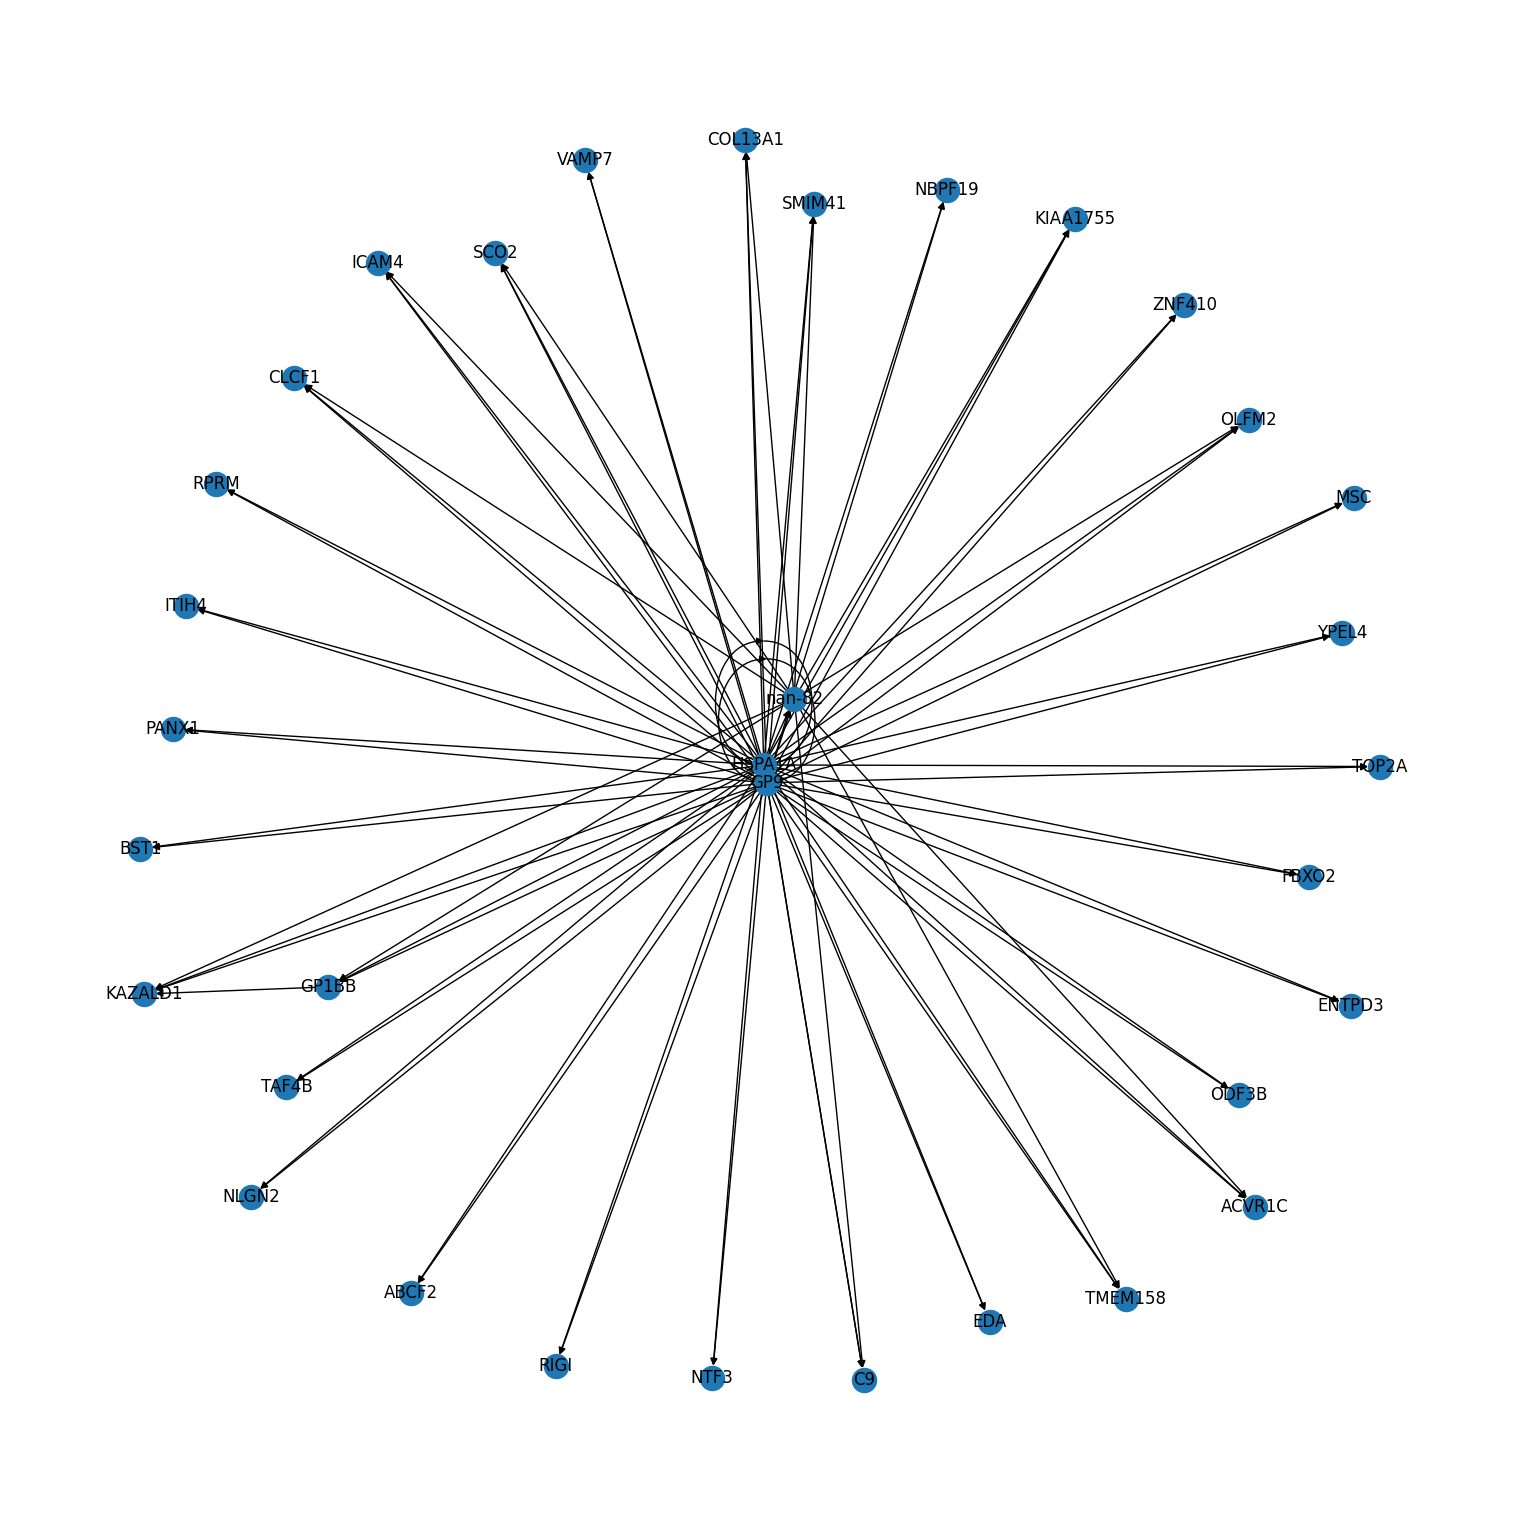

In [ ]:
G = grn_c.plot_subgraph(
    grn_c.var[grn_c.var["cluster_1.5"] == "5"].index.tolist(),
    only=80,
    interactive=False,
)  #


In [ ]:
pnet = pnx.Network(notebook=True, cdn_resources="remote", directed=True)
pnet.from_nx(G)
# first_node = list(G.nodes)[-1]
# pnet.get_node(first_node)['color'] = "red"
pnet.save_graph("../figures/pyvis/grn_c_5.html")

In [ ]:
grn_c.var.loc["nan-82"]  # par of the Glycoside Hydrolase Family

uid                    4giyQrh7tkXI
symbol                       nan-82
ncbi_gene_ids                      
biotype              protein_coding
description           novel protein
synonyms                           
organism_id                       2
public_source_id                9.0
created_by_id                     1
mt                            False
ribo                          False
hb                            False
organism             NCBITaxon:9606
TFs                           False
ensembl_id          ENSG00000269590
centrality                      0.0
cluster_1.5                       5
Name: nan-82, dtype: object